<a href="https://colab.research.google.com/github/vnprr/LifeThread/blob/main/Life_Threat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparations

## Disc

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [18]:
!pip install -q datasets
!pip -q install tqdm
!pip -q install transformers
!pip -q install seaborn
!pip -q install scikit-learn

In [19]:
import os
from sklearn.metrics import accuracy_score, f1_score
from transformers import (pipeline,
                          AutoTokenizer,
                          AutoModelForSequenceClassification,
                          DistilBertForSequenceClassification,
                          Trainer,
                          TrainingArguments,
                          DistilBertTokenizer,
                          BartTokenizer,
                          BartForSequenceClassification,
                          BertTokenizer,
                          BertForSequenceClassification)
import torch
from datasets import Dataset
import pickle
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
from tqdm import tqdm

##Datasets

### Download 1st Dataset

In [20]:
if not os.path.exists('reddit-dataset-rdepression-and-rsuicidewatch.zip'):
  !kaggle datasets download -d xavrig/reddit-dataset-rdepression-and-rsuicidewatch
if not os.path.exists('reddit_depression_suicidewatch.csv'):
  !unzip -q -n reddit-dataset-rdepression-and-rsuicidewatch.zip

In [21]:
!ls

drive						  sample_data
reddit-dataset-rdepression-and-rsuicidewatch.zip  Suicide_Detection.csv
reddit_depression_suicidewatch.csv		  suicide-watch.zip


### Download 2nd Dataset

In [22]:
if not os.path.exists('suicide-watch.zip'):
    !kaggle datasets download -d nikhileswarkomati/suicide-watch
if not os.path.exists('suicide-watch.csv'):
    !unzip -q -n suicide-watch.zip

In [23]:
!ls

drive						  sample_data
reddit-dataset-rdepression-and-rsuicidewatch.zip  Suicide_Detection.csv
reddit_depression_suicidewatch.csv		  suicide-watch.zip


## Process data

In [24]:
# file path
file_path = '/content/drive/MyDrive/Colab Notebooks/SW/combined_data.csv'

# CHECK IF FILE EXISTS
if os.path.exists(file_path):
    print(f"File {file_path} found. Loading data...")
    combined_data = pd.read_csv(file_path)

else:
    print(f"File {file_path} not found. Performing sentiment analysis...")

    # read datasets
    data1 = pd.read_csv('Suicide_Detection.csv')
    data2 = pd.read_csv('reddit_depression_suicidewatch.csv')

    # 1. label mapping
    label_mapping = {'depression': 0, 'non-suicide': 0, 'SuicideWatch': 1, 'suicide': 1}

    data1['class'] = data1['class'].map(label_mapping)
    data2['class'] = data2['label'].map(label_mapping)
    del data1[data1.columns[0]]
    data2 = data2.drop(columns=['label'])

    # 2. lowercase
    data1['text'] = data1['text'].str.lower()
    data2['text'] = data2['text'].str.lower()

    # 3. concatenate data
    combined_data = pd.concat([data1, data2], ignore_index=True)

    # Remove duplicates
    combined_data.drop_duplicates(subset=['text'], inplace=True)

    # Save results
    combined_data.to_csv(file_path, index=False)


File /content/drive/MyDrive/Colab Notebooks/SW/combined_data.csv found. Loading data...


In [25]:
# print(data2.info())
# print(data1.info())
# print(combined_data.info())

print(combined_data.head())

                                                text  class
0  ex wife threatening suiciderecently i left my ...      1
1  am i weird i don't get affected by compliments...      0
2  finally 2020 is almost over... so i can never ...      0
3          i need helpjust help me im crying so hard      1
4  i’m so losthello, my name is adam (16) and i’v...      1


In [26]:
# file path
file_path = '/content/drive/MyDrive/Colab Notebooks/SW/combined_data_with_risk.csv'

# CHECK IF FILE EXISTS
if os.path.exists(file_path):
    print(f"File {file_path} found. Loading data...")
    combined_data = pd.read_csv(file_path)

else:
    # check gpu
    device = 0 if torch.cuda.is_available() else -1

    # load model and tokenizer
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # tonenizer and model pipeline
    sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

    # tqmd for pandas
    tqdm.pandas()

    # Analyze sentiment function
    def analyze_sentiment(post):
        # tokenization,
        #  truncation=True: If the text is longer than the max_length, it will be truncated
        #  padding='max_length': Shorter texts will be padded with special tokens to ensure all inputs have the same length.
        #  max_length=512: Sets the maximum length of the tokenized sequence.
        #  return_tensors='pt': Specifies that the function should return PyTorch tensors.
        tokens = tokenizer(post, truncation=True, padding='max_length', max_length=512, return_tensors='pt') # Changed max_length to 512
        # Sentument analysis
        results = sentiment_analysis(post, truncation=True) # Added truncation to the pipeline call
        return results[0]['score']

    # Start analysis
    combined_data['sentiment'] = combined_data['text'].progress_apply(analyze_sentiment)

    # Save on g drive
    combined_data.to_csv('/content/drive/MyDrive/Colab Notebooks/SW/combined_data_with_risk.csv', index=False)


print(combined_data.head())

File /content/drive/MyDrive/Colab Notebooks/SW/combined_data_with_risk.csv found. Loading data...
                                                text  class  sentiment
0  ex wife threatening suiciderecently i left my ...      1   0.993805
1  am i weird i don't get affected by compliments...      0   0.999523
2  finally 2020 is almost over... so i can never ...      0   0.999436
3          i need helpjust help me im crying so hard      1   0.998133
4  i’m so losthello, my name is adam (16) and i’v...      1   0.996261


# Sentiment Analysis

In [ ]:
# initialize quantile transformer
quantile_transformer = QuantileTransformer(output_distribution='uniform')

# transform
combined_data['sentiment'] = quantile_transformer.fit_transform(combined_data[['sentiment']])

# show normalized
print(combined_data.head())

In [ ]:
# histogram
combined_data['sentiment'][combined_data['class'] == 0].plot(kind='hist', bins=20, edgecolor='black', alpha=0.5, label='non-suicidial')
combined_data['sentiment'][combined_data['class'] == 1].plot(kind='hist', bins=20, edgecolor='black', alpha=0.5, label='suicidial')
plt.title('Distribution of values in the sentiment column')
plt.xlabel('Sentiment values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# min
print("min:", combined_data['sentiment'].min())

# max
print("max:", combined_data['sentiment'].max())

#accuracy
print("accuracy score:", accuracy_score(y_true=combined_data['class'], y_pred=combined_data['sentiment'] > 0.5))


#### Sentiment analysis reveals a noticeable trend, but a significant portion of suicidal posts remain difficult to identify based solely on sentiment.

# Training

## Prepare Datasets

In [27]:
combined_data = combined_data.drop(columns=['sentiment'])


In [28]:
combined_data.head()

,text,class
0,ex wife threatening suiciderecently i left my ...,1
1,am i weird i don't get affected by compliments...,0
2,finally 2020 is almost over... so i can never ...,0
3,i need helpjust help me im crying so hard,1
4,"i’m so losthello, my name is adam (16) and i’v...",1


In [29]:
# train / test split
train_data, test_data = train_test_split(combined_data,
                                         test_size=0.2,   #małe liczby najlepsze dla eksperymentowania
                                         train_size=0.2,
                                         random_state=42
                                         )

X_train = train_data['text']
X_test = test_data['text']
y_train = train_data['class']
y_test = test_data['class']

print(f"train size: {len(train_data)}")
print(f"test size: {len(test_data)}")

train size: 50481
test size: 50481


## Simple Models

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# text to numbers convertion TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Model: **Stochastic Gradient Descent**

In [ ]:
# Hyperparameters

# from sklearn.model_selection import GridSearchCV

# model_sgd = SGDClassifier(loss='log_loss', max_iter=1000)

# # grid:
# param_grid = {
#     'alpha': [0.0001, 0.001, 0.01],
#     'penalty': ['l1', 'l2'],
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(model_sgd, param_grid, cv=5)

# # fit to train data
# grid_search.fit(X_train_tfidf, y_train)

# # show parameters and test
# print(grid_search.best_params_)
# best_model = grid_search.best_estimator_

In [ ]:

model_sgd = SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=1000, penalty='l2')

# train
history_sgd = model_sgd.fit(X_train_tfidf, y_train)

# test
accuracy_sgd = model_sgd.score(X_test_tfidf, y_test)
print(f"Dokładność modelu regresji logistycznej: {accuracy:.4f}")

NameError: name 'X_train_tfidf' is not defined

In [ ]:
# save on disc

import pickle

filename = '/content/drive/MyDrive/Programowanie/Life Thread/Models/SDGclassifier1.sav'
pickle.dump(model_sgd, open(filename, 'wb'))

#### Podsumowanie
Najlepsze wartości:
`model = SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=10000, penalty='l2')`

Wartość max_iter została zoptymalizowana do 1000

Model osiągnął satysfakcjonujący wynik accuracy: 0.8932

---



### Model: **Naive Bayes**

In [ ]:
#Hyperparameters

model_nb = MultinomialNB()

# grid:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False],
}

grid_search = GridSearchCV(model_nb, param_grid, cv=5)

# fit to train data
grid_search.fit(X_train_tfidf, y_train)

# Test
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test_tfidf, y_test)
print(f"Accuracy: {accuracy:.4f}")


{'alpha': 0.1, 'fit_prior': True}
Dokładność Naive Bayes: 0.8743


In [ ]:

model_nb = MultinomialNB(alpha=0.5, fit_prior=False)
model_nb.fit(X_train_tfidf, y_train)
accuracy = model_nb.score(X_test_tfidf, y_test)
print(f"Accuracy: {accuracy:.4f}")

Dokładność Naive Bayes: 0.8739


In [ ]:
# save on disc


filename = '/content/drive/MyDrive/Programowanie/Life Thread/Models/NaiveBayes1.sav'
pickle.dump(model_nb, open(filename, 'wb'))

#### Podsumowanie

Najlepsze wartości: `'alpha': 0.1, 'fit_prior': True`

Model osiągnął satysfakcjonujący wynik accuracy: 0.8739

---



### Model: **Support Vector Machine**

In [ ]:
#Hyperparameters

# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC # Import the SVC class

# # Assuming you want to tune an SVM classifier, create an instance of SVC
# model_svm = SVC()

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': ['scale', 'auto', 0.1, 1, 10]
# }

# grid_search = GridSearchCV(model_svm, param_grid, cv=5, scoring='accuracy') # 5-fold cross validation # Changed 'model' to 'model_svm'
# grid_search.fit(X_train_tfidf, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# best_model = grid_search.best_estimator_

Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.8980190174326467


In [ ]:
# Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
# Best score:  0.8980190174326467


# Create and start the process
model_svc = SVC(C=100, gamma='scale', kernel='rbf')

model_svc.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_svc.fit(X_train_tfidf, y_train)


# Calculate accuracy
accuracy = model_svc.score(X_test_tfidf, y_test)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9004


In [ ]:
# save on disc

filename = '/content/drive/MyDrive/Programowanie/Life Thread/Models/SVC1.sav'
pickle.dump(model_svc, open(filename, 'wb'))

#### Summary

**Support Vector Classifier** model was trained using the scikit-learn library.

The best hyperparameters found for the model are:

`C: 100, gamma: 'scale', kernel: 'rbf'`

These hyperparameters were found using GridSearchCV, which allowed for searching the hyperparameter space and selecting the best values.

The model achieved an accuracy score of **0.9004** on the validation set.

The training and testing were performed on the CPU and 5% of dataset for optimization.


---



## BERT Models

### Model: **BERT**

In [30]:
# Convert pandas DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

# tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# rename
if 'class' in train_dataset.column_names:
  train_dataset = train_dataset.rename_column("class", "labels")
  test_dataset = test_dataset.rename_column("class", "labels")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/50481 [00:00<?, ? examples/s]

Map:   0%|          | 0/50481 [00:00<?, ? examples/s]

In [ ]:
# # Metrics function
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     f1 = f1_score(labels, preds, average="weighted")
#     acc = accuracy_score(labels, preds)
#     return {"accuracy": acc, "f1": f1}

# Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2, ignore_mismatched_sizes=True
)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define training args
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_steps=10_000,
    logging_dir='./logs',
    logging_steps=200,
    fp16=True,  # Enable mixed precision training
    report_to="none"  # Disable reporting for speed optimization
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
    #compute_metrics=compute_metrics
)

# Start training
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
0,0.138200,No log
1,0.083700,No log
2,0.036100,No log


TrainOutput(global_step=2364, training_loss=0.0961090798305376, metrics={'train_runtime': 2771.6409, 'train_samples_per_second': 54.64, 'train_steps_per_second': 0.853, 'total_flos': 3.980396667697152e+16, 'train_loss': 0.0961090798305376, 'epoch': 2.9966724766281096})

In [31]:
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_model_0.2')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_tokenizer_0.2')

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_steps=10_000,
    logging_dir='./logs',
    logging_steps=200,
    fp16=True,  # Enable mixed precision training
    report_to="none"  # Disable reporting for speed optimization
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
    #compute_metrics=compute_metrics
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [32]:
predictions = trainer.predict(test_dataset)
eval = trainer.evaluate(test_dataset)

In [40]:
print(eval)
labels = predictions.label_ids

loss = predictions.metrics['test_loss']
accuracy = accuracy_score(labels, predictions.predictions.argmax(-1))

print(f"accuracy: {accuracy}")
print(f"loss: {loss}")

{'eval_loss': 0.16288645565509796, 'eval_model_preparation_time': 0.0037, 'eval_runtime': 214.0912, 'eval_samples_per_second': 235.792, 'eval_steps_per_second': 29.478}
accuracy: 0.9544383035201363
loss: 0.16288645565509796


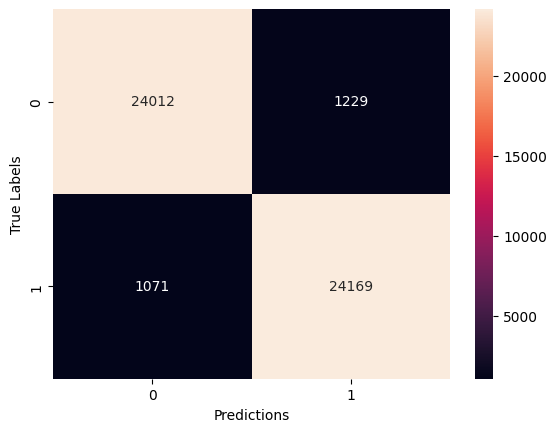

In [42]:
# Extract labels and predictions
labels = test_dataset['labels']
preds = predictions.predictions.argmax(-1)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.show()

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_model_0.2')
tokenizer.save_pretrained('/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_tokenizer_0.2')

('/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_tokenizer_0.2/tokenizer_config.json',
 '/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_tokenizer_0.2/special_tokens_map.json',
 '/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_tokenizer_0.2/vocab.txt',
 '/content/drive/MyDrive/Programowanie/Life Thread/Models/bert_tokenizer_0.2/added_tokens.json')

#### Summary

##### **BERT Version 1**

trained on 5% dataset

```
Epoch	 Training Loss
1	     0.207500
2	     0.096700
3	     0.044100

TrainOutput(
  global_step=2367,
  training_loss=0.12685552427020313,
  metrics={
    'train_runtime': 1300.4625,
    'train_samples_per_second': 29.113,
    'train_steps_per_second': 1.82,
    'total_flos': 9961384555929600.0,
    'train_loss': 0.12685552427020313,
    'epoch': 3.0
  })
```

##### **BERT Version 2**

```
Accuracy: 0.9544
Loss:     0.1629
```

```
Epoch	 Training Loss
0	     0.138200
1	     0.083700
2	     0.036100

TrainOutput(
  global_step=2364,
  training_loss=0.0961090798305376,
  metrics={
    'train_runtime': 2771.6409,
    'train_samples_per_second': 54.64,
    'train_steps_per_second': 0.853,
    'total_flos': 3.980396667697152e+16,
    'train_loss': 0.0961090798305376,
    'epoch': 2.9966724766281096
  })
```

Training the **BERT** model on **20%** of the available data yielded very promising results. The achieved accuracy of **0.9544** indicates that the model generalizes well and can classify examples correctly with high precision.

### Model: **DistilBERT**

In [ ]:
# Convert pandas DataFrame to Dataset
train_dataset_db = Dataset.from_pandas(train_data)
test_dataset_db = Dataset.from_pandas(test_data)

# load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# tokenization
train_dataset_db = train_dataset_db.map(tokenize_function, batched=True)
test_dataset_db = test_dataset_db.map(tokenize_function, batched=True)

# rename
if 'class' in train_dataset_db.column_names:
  train_dataset_db = train_dataset_db.rename_column("class", "labels")
  test_dataset_db = test_dataset_db.rename_column("class", "labels")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/50481 [00:00<?, ? examples/s]

Map:   0%|          | 0/50481 [00:00<?, ? examples/s]

In [ ]:
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     f1 = f1_score(labels, preds, average="weighted")
#     acc = accuracy_score(labels, preds)
#     return {"accuracy": acc, "f1": f1}

# Load model
model_db = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_db.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",  # Save at the end of each epoch
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2
)

# Define trainer
trainer_db = Trainer(
    model=model_db,
    args=training_args,
    train_dataset=train_dataset_db,
    eval_dataset=test_dataset_db
    #compute_metrics=compute_metrics
)

# Train the model
trainer_db.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.153400,0.132797
2,0.108000,0.127484
3,0.083300,0.138407


TrainOutput(global_step=2367, training_loss=0.12814958839916105, metrics={'train_runtime': 2641.8545, 'train_samples_per_second': 57.325, 'train_steps_per_second': 0.896, 'total_flos': 2.006126025466061e+16, 'train_loss': 0.12814958839916105, 'epoch': 3.0})

In [ ]:
results = trainer_db.evaluate()
predictions = trainer_db.predict(test_dataset_db)

In [ ]:
print(results)

loss = predictions.metrics['test_loss']
accuracy = accuracy_score(labels, preds)

print(f"accuracy: {accuracy}")
print(f"loss: {loss}")

{'eval_loss': 0.13840675354003906, 'eval_runtime': 219.3073, 'eval_samples_per_second': 230.184, 'eval_steps_per_second': 3.598, 'epoch': 3.0}
accuracy: 0.9510112715675204
loss: 0.13840675354003906


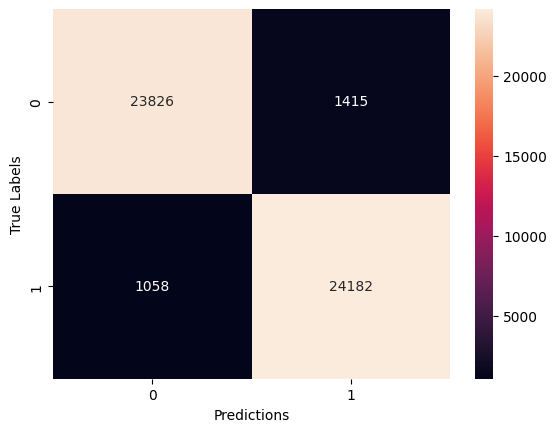

In [ ]:
# Extract labels and predictions
labels = test_dataset['class']
preds = predictions_db.predictions.argmax(-1)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.show()

In [ ]:
model_db.save_pretrained('/content/drive/MyDrive/Programowanie/Life Thread/Models/distilbert_model_0.2')
tokenizer_db.save_pretrained('/content/drive/MyDrive/Programowanie/Life Thread/Models/distilbert_tokenizer_0.2')

#### Podsumowanie

Na **5% danych** model osiągnął niewiele gorsze rezultaty przy mniejszej złożoności od BERT.

Wydajność na zbiorze testowym:

```
Accuracy: 0.9362
Loss:     0.1701
```

Na **20% danych** model osiągnął minimalnie gorsze  rezultaty przy mniejszej złożoności od BERT.

Wydajność na zbiorze testowym:

```
Accuracy: 0.9510
Loss:     0.1384
```



---



#Trash